In [8]:
# sentiment_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# import os


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Load dataset
df = pd.read_csv('dataset_labeled.csv')

# Verifikasi kolom
print("Kolom tersedia:", df.columns.tolist())
print("Contoh data awal:")
print(df.head())

# untuk memastikan kolom label dan teks tersedia
TEXT_COLUMN = 'content'
LABEL_COLUMN = 'label'
if TEXT_COLUMN not in df.columns or LABEL_COLUMN not in df.columns:
    raise ValueError("Dataset harus memiliki kolom 'content' dan 'label'")


Kolom tersedia: ['userName', 'content', 'score', 'label', 'at']
Contoh data awal:
          userName                                            content  score  \
0  Pengguna Google                                              bagus      5   
1  Pengguna Google  sangat membantu, terima kasih banyak jkn sukse...      5   
2  Pengguna Google                                             mantul      5   
3  Pengguna Google                                               good      5   
4  Pengguna Google                                             mantap      5   

     label                   at  
0  positif  2025-05-24 13:48:06  
1  positif  2025-05-24 13:26:27  
2  positif  2025-05-24 13:24:33  
3  positif  2025-05-24 12:45:05  
4  positif  2025-05-24 12:28:22  



Distribusi Sentimen:
label
negatif    46846
positif    45790
netral      4437
Name: count, dtype: int64


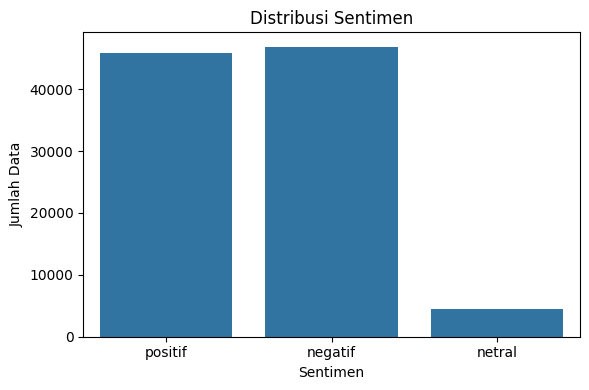

In [11]:
# Analisis distribusi label sentimen
if 'label' not in df.columns:
    raise ValueError("Kolom 'label' tidak ditemukan dalam dataset")

sentiment_counts = df['label'].value_counts()
print("\nDistribusi Sentimen:")
print(sentiment_counts)

# Visualisasi distribusi sentimen
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()


In [12]:
# Encode label menjadi integer
label_encoder = LabelEncoder()
df[LABEL_COLUMN] = label_encoder.fit_transform(df[LABEL_COLUMN])

In [13]:
# Tokenisasi teks
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df[TEXT_COLUMN])
sequences = tokenizer.texts_to_sequences(df[TEXT_COLUMN])

In [14]:
# Padding sequence
X = pad_sequences(sequences, padding='post', maxlen=100)
y = df[LABEL_COLUMN].values


In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [16]:
# Konfigurasi umum
vocab_size = 20000
embedding_dim = 128
input_length = 100
num_classes = len(np.unique(y))

# Tempat simpan hasil akurasi
results = []

In [17]:
# SKEMA 1 Bidirectional LSTM + GlobalAveragePooling
model1 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=input_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)
train_acc1 = model1.evaluate(X_train, y_train)[1]
test_acc1 = model1.evaluate(X_test, y_test)[1]
results.append(['BiLSTM + GAP', train_acc1, test_acc1])
model1.save('model_bilstm.h5')


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


971/971 ━━━━━━━━━━━━━━━━━━━━ 297s 301ms/step - accuracy: 0.7875 - loss: 0.5356 - val_accuracy: 0.8878 - val_loss: 0.3513
Epoch 2/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 316s 325ms/step - accuracy: 0.9006 - loss: 0.3137 - val_accuracy: 0.8945 - val_loss: 0.3311
Epoch 3/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 298s 300ms/step - accuracy: 0.9103 - loss: 0.2743 - val_accuracy: 0.8924 - val_loss: 0.3332
Epoch 4/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 294s 303ms/step - accuracy: 0.9196 - loss: 0.2433 - val_accuracy: 0.8911 - val_loss: 0.3480
Epoch 5/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 325s 306ms/step - accuracy: 0.9267 - loss: 0.2159 - val_accuracy: 0.8798 - val_loss: 0.3799
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.9363 - loss: 0.1930
607/607 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8830 - loss: 0.3602


In [18]:
# SKEMA 2 CNN + GlobalMaxPooling
model2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=input_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)
train_acc2 = model2.evaluate(X_train, y_train)[1]
test_acc2 = model2.evaluate(X_test, y_test)[1]
results.append(['CNN + GMP', train_acc2, test_acc2])
model2.save('model_cnn.h5')


Epoch 1/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 114s 115ms/step - accuracy: 0.8590 - loss: 0.4328 - val_accuracy: 0.8936 - val_loss: 0.3271
Epoch 2/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 142s 115ms/step - accuracy: 0.9110 - loss: 0.2727 - val_accuracy: 0.8931 - val_loss: 0.3281
Epoch 3/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 148s 121ms/step - accuracy: 0.9315 - loss: 0.2029 - val_accuracy: 0.8880 - val_loss: 0.3763
Epoch 4/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 135s 114ms/step - accuracy: 0.9552 - loss: 0.1370 - val_accuracy: 0.8673 - val_loss: 0.4326
Epoch 5/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 113s 116ms/step - accuracy: 0.9740 - loss: 0.0843 - val_accuracy: 0.8767 - val_loss: 0.5571
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9832 - loss: 0.0580
607/607 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8825 - loss: 0.5205


In [19]:
# SKEMA 3 Bidirectional GRU + GlobalAveragePooling
model3 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=input_length),
    Bidirectional(GRU(64, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)
train_acc3 = model3.evaluate(X_train, y_train)[1]
test_acc3 = model3.evaluate(X_test, y_test)[1]
results.append(['BiGRU + GAP', train_acc3, test_acc3])
model3.save('model_bigru.h5')


Epoch 1/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 327s 331ms/step - accuracy: 0.7855 - loss: 0.5110 - val_accuracy: 0.8958 - val_loss: 0.3257
Epoch 2/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 322s 332ms/step - accuracy: 0.9067 - loss: 0.2865 - val_accuracy: 0.8951 - val_loss: 0.3197
Epoch 3/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 329s 339ms/step - accuracy: 0.9186 - loss: 0.2486 - val_accuracy: 0.8924 - val_loss: 0.3375
Epoch 4/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 378s 335ms/step - accuracy: 0.9242 - loss: 0.2254 - val_accuracy: 0.8900 - val_loss: 0.3638
Epoch 5/5
971/971 ━━━━━━━━━━━━━━━━━━━━ 383s 336ms/step - accuracy: 0.9343 - loss: 0.1933 - val_accuracy: 0.8766 - val_loss: 0.4063
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 91s 37ms/step - accuracy: 0.9453 - loss: 0.1720
607/607 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8826 - loss: 0.3859


In [20]:
# Simpan hasil akurasi ke CSV
results_df = pd.DataFrame(results, columns=['Skema', 'Akurasi Training', 'Akurasi Testing'])
results_df.to_csv('hasil_akurasi.csv', index=False)
print("\nHasil Akurasi Tiap Skema:")
print(results_df)

# Inference dari model terbaik (BiLSTM)
pred_probs = model1.predict(X_test)
y_pred = np.argmax(pred_probs, axis=1)
print("\nClassification Report (BiLSTM):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Hasil Akurasi Tiap Skema:
          Skema  Akurasi Training  Akurasi Testing
0  BiLSTM + GAP          0.926279         0.881020
1     CNN + GMP          0.963275         0.879732
2   BiGRU + GAP          0.932576         0.880556
607/607 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step

Classification Report (BiLSTM):
              precision    recall  f1-score   support

     negatif       0.87      0.92      0.89      9369
      netral       0.22      0.06      0.10       888
     positif       0.91      0.92      0.92      9158

    accuracy                           0.88     19415
   macro avg       0.67      0.63      0.64     19415
weighted avg       0.86      0.88      0.87     19415



In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load trained modelnya
model1 = load_model('model_bilstm.h5')
model2 = load_model('model_cnn.h5')
model3 = load_model('model_bigru.h5')

def predict_sentiment(text, tokenizer, label_encoder, max_len=100):
    """
    Predicts sentiment for a given text using the provided tokenizer and label encoder.

    Args:
        text (str): The input text.
        tokenizer: The fitted Keras Tokenizer object.
        label_encoder: The fitted scikit-learn LabelEncoder object.
        max_len (int): Maximum sequence length for padding.

    Returns:
        str: The predicted sentiment label.
    """
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=max_len)

    # Predict probabilities untuk tiap model
    pred_probs1 = model1.predict(padded_sequence, verbose=0)
    pred_probs2 = model2.predict(padded_sequence, verbose=0)
    pred_probs3 = model3.predict(padded_sequence, verbose=0)

    # Get predicted class index untuk tiap model
    predicted_class_index1 = np.argmax(pred_probs1, axis=1)[0]
    predicted_class_index2 = np.argmax(pred_probs2, axis=1)[0]
    predicted_class_index3 = np.argmax(pred_probs3, axis=1)[0]

    # Decode predicted class index kembali ke label original
    predicted_label1 = label_encoder.inverse_transform([predicted_class_index1])[0]
    predicted_label2 = label_encoder.inverse_transform([predicted_class_index2])[0]
    predicted_label3 = label_encoder.inverse_transform([predicted_class_index3])[0]

    return predicted_label1, predicted_label2, predicted_label3

# Input text untuk test
test_comment = "Aplikasi ini sangat membantu"

# Predict sentiment menggunakan 3 model
sentiment_model1, sentiment_model2, sentiment_model3 = predict_sentiment(test_comment, tokenizer, label_encoder)

print(f"Teks Uji: '{test_comment}'")
print(f"Prediksi Model 1 (BiLSTM + GAP): {sentiment_model1}")
print(f"Prediksi Model 2 (CNN + GMP): {sentiment_model2}")
print(f"Prediksi Model 3 (BiGRU + GAP): {sentiment_model3}")

# Contoh dengan text lain
test_comment_negative = "mengapa verifikasi wajah selalu gagal ya ?"
sentiment_model1_neg, sentiment_model2_neg, sentiment_model3_neg = predict_sentiment(test_comment_negative, tokenizer, label_encoder)

print(f"\nTeks Uji: '{test_comment_negative}'")
print(f"Prediksi Model 1 (BiLSTM + GAP): {sentiment_model1_neg}")
print(f"Prediksi Model 2 (CNN + GMP): {sentiment_model2_neg}")
print(f"Prediksi Model 3 (BiGRU + GAP): {sentiment_model3_neg}")


Teks Uji: 'Aplikasi ini sangat membantu'
Prediksi Model 1 (BiLSTM + GAP): positif
Prediksi Model 2 (CNN + GMP): positif
Prediksi Model 3 (BiGRU + GAP): positif

Teks Uji: 'mengapa verifikasi wajah selalu gagal ya ?'
Prediksi Model 1 (BiLSTM + GAP): negatif
Prediksi Model 2 (CNN + GMP): negatif
Prediksi Model 3 (BiGRU + GAP): negatif


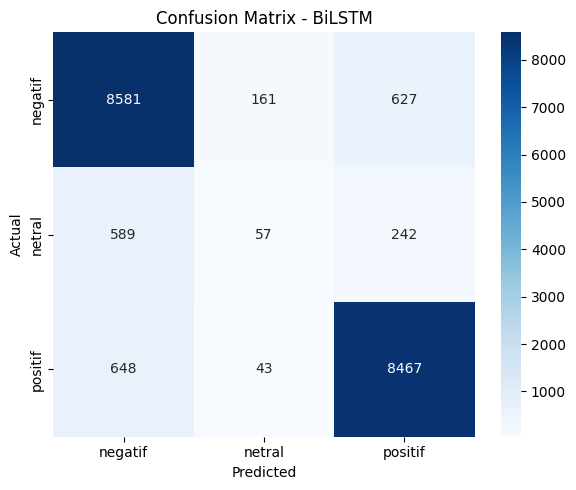

In [22]:
# Confusion Matrixnya
def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_pred, label_encoder.classes_, "Confusion Matrix - BiLSTM")


In [ ]:
# requirements
pandas>=1.0.0
numpy>=1.18.0
matplotlib>=3.1.0
seaborn>=0.11.0
tensorflow>=2.0.0
scikit-learn>=0.22.0
gspread>=3.0.0
oauth2client>=4.1.3
